# Using CNN to Classify Colon Histopathological Images

**Import Necessary Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from monai.networks.nets import ResNetFeatures, ResNet, HighResNet
from torchinfo import summary
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# Interpretability imports
import shap
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries

ModuleNotFoundError: No module named 'matplotlib'

In [4]:
# Set Device for GPU Acceleration with Nvidia cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


**Define Paths and Hyperparameters**

In [5]:
# Define dataset location and essential training hyperparameters.
DATA_DIR = 'Dataset/lung_colon_image_set/colon_image_sets'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

**Prepare Dataframe**

In [6]:
# Function to extract file paths and corresponding labels from the dataset directory.
def prepare_dataframe(data_dir):
    filepaths, labels = [], []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})


df = prepare_dataframe(DATA_DIR)

In [7]:
# Split dataset into training, validation, and testing sets with an 80-10-10 ratio.
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, random_state=123)

# Create a dictionary mapping class labels to numerical indices.
classes = train_df["labels"].unique()
class_to_idx = {label: idx for idx, label in enumerate(classes)}

print("Classes:", classes)
print("Class to Index Mapping:", class_to_idx)


Classes: ['colon_n' 'colon_aca']
Class to Index Mapping: {'colon_n': 0, 'colon_aca': 1}


**Dataset Class**

In [8]:
# Dataset class to load images and corresponding labels.
class ColonCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_to_idx=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = class_to_idx or {label: idx for idx, label in enumerate(dataframe['labels'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_idx = self.class_to_idx[label]
        return image, torch.tensor(label_idx)
    

**Define Image Transforms & Create DataLoaders**

DataLoaders created successfully.


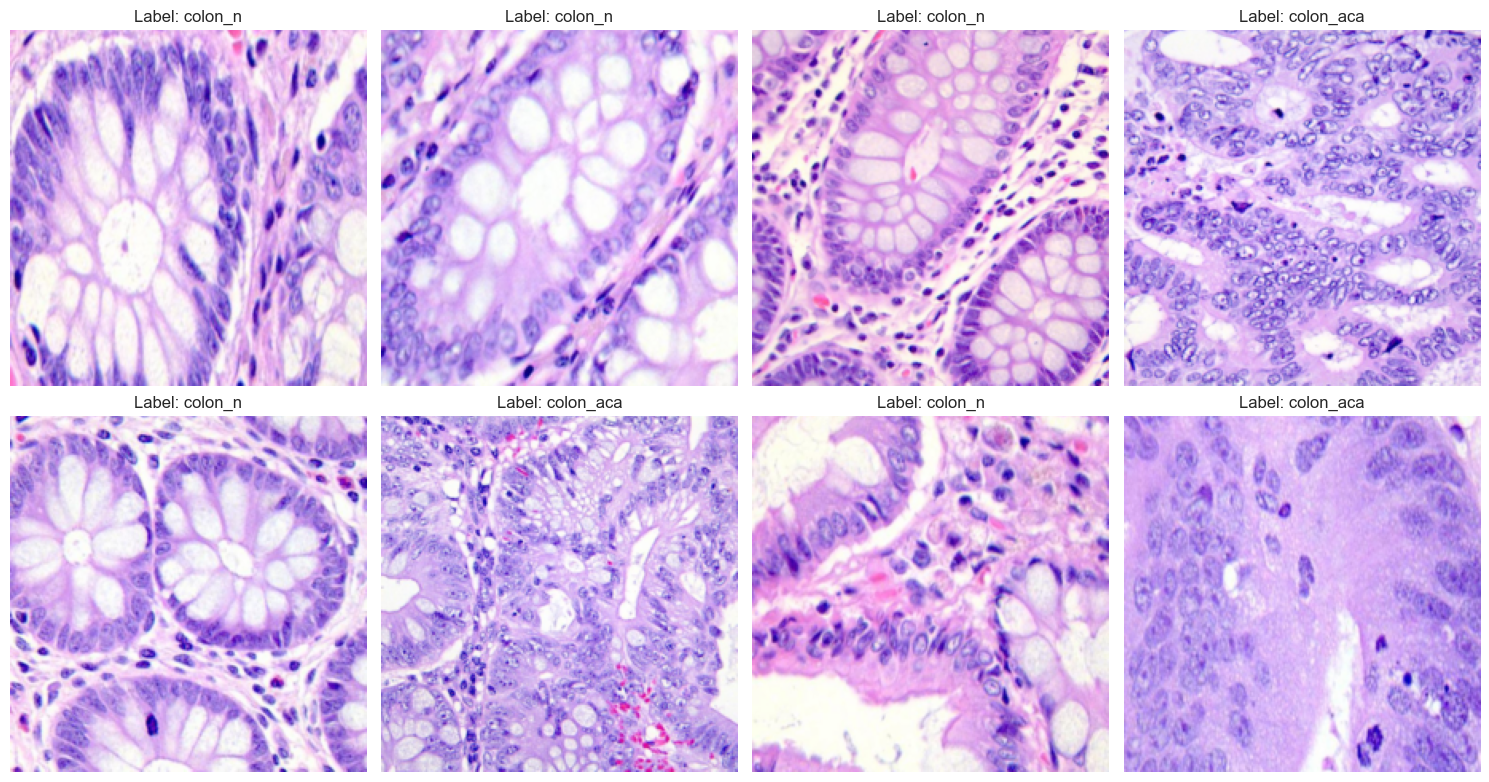

In [9]:
# Apply preprocessing transformations for images before feeding into the model
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset instances for training, validation, and testing.
train_dataset = ColonCancerDataset(train_df, transform=transform, class_to_idx=class_to_idx)
valid_dataset = ColonCancerDataset(valid_df, transform=transform, class_to_idx=class_to_idx)
test_dataset = ColonCancerDataset(test_df, transform=transform, class_to_idx=class_to_idx)

# Load datasets into DataLoader objects for batch processing.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully.")

# Visualise a Batch of Images
# Create Dataset
dataset = ColonCancerDataset(train_df, transform=transform, class_to_idx=class_to_idx)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)  # num_workers=0 for Windows compatibility

# Load a batch
batch = next(iter(train_loader))
images, labels = batch

# Reverse the class_to_idx mapping
index_to_label = {idx: label for label, idx in class_to_idx.items()}

# Plot the first 8 images in the batch
plt.figure(figsize=(15, 8))
for i in range(8):  # Adjust based on batch size
    plt.subplot(2, 4, i + 1)
    image = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Un-normalise the image
    image = np.clip(image, 0, 1)  # Clip values to valid range
    label_name = index_to_label[labels[i].item()]  # Convert label index to class name
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()


**Model Definition**

In [10]:
# Load deep learning model from MONAI library and modify it for classification.


def get_model(num_classes):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model.to(DEVICE)


# Initialize the model
model = get_model(num_classes=len(classes))
print(model)


# Print model summary
print(summary(model, input_size=(BATCH_SIZE, 3, *IMG_SIZE)))



The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\tobio/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 51.4MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

**Training the model with Mixed Precision and Cosine Annealing**

In [11]:
# Define training function with mixed precision for efficiency and learning rate scheduling.

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    scaler = GradScaler(device='cuda')  # For Mixed Precision on CUDA

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            with autocast(device_type='cuda'):
  # Enable Mixed Precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale the gradients
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(loss=loss.item(), accuracy=correct / total)

        # Step the scheduler (Cosine Annealing)
        scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

**Evaluating the Model**

In [12]:
# Function to evaluate the trained model on the test dataset and generate performance metrics.
def evaluate_model(model, test_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()



**Load Trained Model**

In [13]:
# Function to load a previously trained model
def load_model(model_path, num_classes):
    model = get_model(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    print(f"Model loaded from {model_path}")
    return model

**Grad-CAM Heatmap Generation**

In [14]:
from captum.attr import GuidedGradCam, LayerGradCam, visualization

# Function to generate Grad-CAM heatmaps for interpretability.
def generate_grad_cam(model, image_path, target_layer, class_idx=None):
    """
    Generates a Grad-CAM heatmap for the given image.
    """
    model.eval()

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Define Grad-CAM
    grad_cam = LayerGradCam(model, target_layer)

    # Generate attributions
    attributions = grad_cam.attribute(image_tensor, target=class_idx)

    # Convert to numpy and visualise
    heatmap = visualization.visualize_image_attr(
        attributions.cpu().detach().numpy()[0], 
        image_tensor.cpu().detach().numpy()[0]
    )

    return heatmap

from captum.attr import LayerGradCam, visualization

def apply_grad_cam_overlay(model, image_path, target_layer, class_to_idx):
    """
    Applies Grad-CAM on an image and overlays the heatmap on the original image.
    """
    model.eval()

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Define Grad-CAM
    grad_cam = LayerGradCam(model, target_layer)

    # Get model prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_class = list(class_to_idx.keys())[list(class_to_idx.values()).index(pred_idx)]
    
    # Generate Grad-CAM heatmap
    attributions = grad_cam.attribute(image_tensor, target=pred_idx)
    
    # Convert attributions to a heatmap
    heatmap = attributions.squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU: remove negative values
    heatmap = cv2.resize(heatmap, (224, 224))  # Resize to image size
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize between 0 and 1
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit
    
    # Convert original image to numpy
    image_np = np.array(image.resize((224, 224)))  # Resize for consistency
    
    # Apply heatmap to original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Convert heatmap to color
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)  # Blend images

    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({probs.max().item():.2f})")
    plt.show()




**Training the Model**

In [15]:
# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Train Model with LR Scheduling
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, NUM_EPOCHS)


Epoch 1/10: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s, accuracy=0.992, loss=0.00273] 


Epoch [1/10] - Loss: 0.0246, Accuracy: 0.9922, LR: 0.000098


Epoch 2/10: 100%|██████████| 500/500 [02:38<00:00,  3.16it/s, accuracy=1, loss=0.00158]     


Epoch [2/10] - Loss: 0.0027, Accuracy: 0.9998, LR: 0.000091


Epoch 3/10: 100%|██████████| 500/500 [02:39<00:00,  3.13it/s, accuracy=1, loss=0.000129]    


Epoch [3/10] - Loss: 0.0008, Accuracy: 0.9999, LR: 0.000080


Epoch 4/10: 100%|██████████| 500/500 [02:41<00:00,  3.09it/s, accuracy=1, loss=2.41e-5] 


Epoch [4/10] - Loss: 0.0001, Accuracy: 1.0000, LR: 0.000066


Epoch 5/10: 100%|██████████| 500/500 [02:43<00:00,  3.05it/s, accuracy=1, loss=0.000142]


Epoch [5/10] - Loss: 0.0001, Accuracy: 1.0000, LR: 0.000051


Epoch 6/10: 100%|██████████| 500/500 [02:47<00:00,  2.98it/s, accuracy=1, loss=5.32e-5] 


Epoch [6/10] - Loss: 0.0002, Accuracy: 1.0000, LR: 0.000035


Epoch 7/10: 100%|██████████| 500/500 [02:45<00:00,  3.02it/s, accuracy=1, loss=1.39e-5] 


Epoch [7/10] - Loss: 0.0002, Accuracy: 1.0000, LR: 0.000021


Epoch 8/10: 100%|██████████| 500/500 [02:41<00:00,  3.09it/s, accuracy=1, loss=3.51e-5] 


Epoch [8/10] - Loss: 0.0001, Accuracy: 1.0000, LR: 0.000010


Epoch 9/10: 100%|██████████| 500/500 [02:39<00:00,  3.14it/s, accuracy=1, loss=2.03e-5] 


Epoch [9/10] - Loss: 0.0001, Accuracy: 1.0000, LR: 0.000003


Epoch 10/10: 100%|██████████| 500/500 [02:39<00:00,  3.14it/s, accuracy=1, loss=1.89e-5] 

Epoch [10/10] - Loss: 0.0005, Accuracy: 0.9999, LR: 0.000001


**Save and Load model**

In [29]:
# Save the trained model
MODEL_PATH = "resnet50_colon_cancer.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to resnet50_colon_cancer.pth


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

Model loaded from resnet50_colon_cancer.pth
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00       390
   colon_aca       1.00      1.00      1.00       410

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


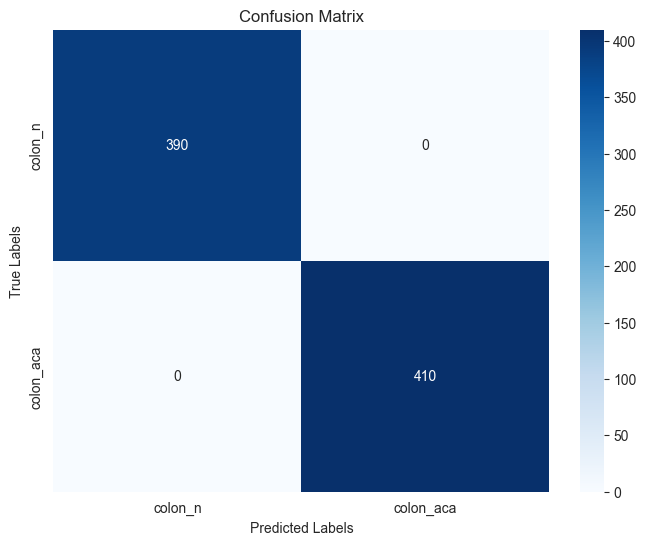

In [30]:
# Load the model and evaluate performance
model = load_model("resnet50_colon_cancer.pth", num_classes=len(classes))
evaluate_model(model, test_loader, classes)

**Testing Model against Test split**

In [18]:
# Function to test the trained model on the test dataset and print accuracy.
def test_model_on_dataset(model, test_loader, classes):
    """
    Runs the model on the test dataset and prints accuracy.
    """
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Run test
test_model_on_dataset(model, test_loader, classes)


Test Accuracy: 100.00%


**Visualizing Model Predictions**

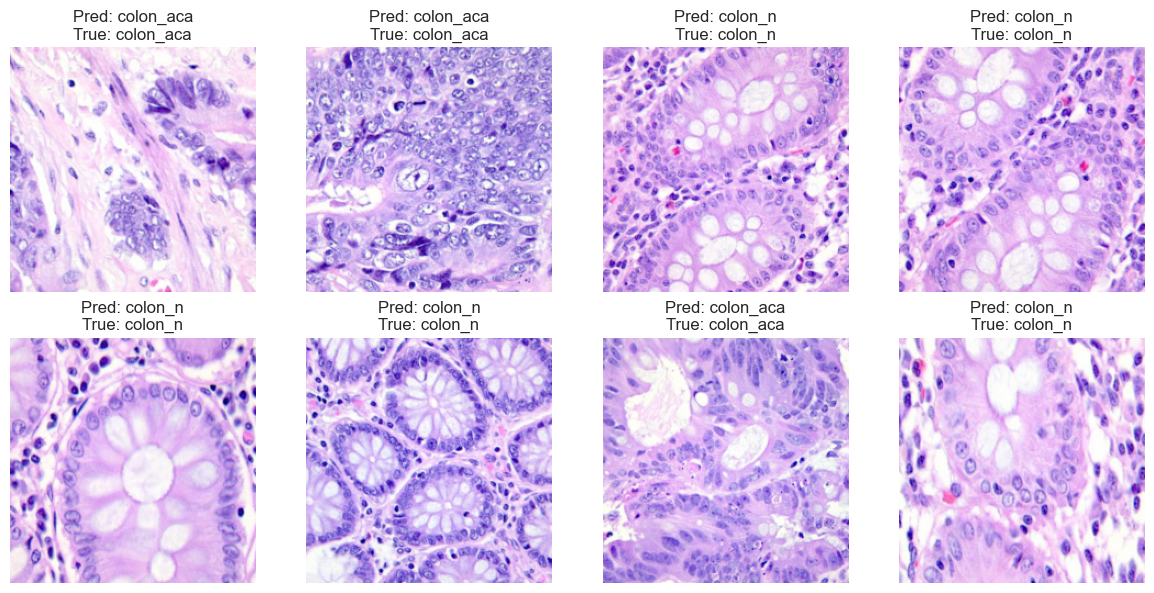

In [19]:
def plot_model_predictions(model, test_loader, classes, num_images=8):
    """
    Displays a batch of images with model predictions.
    """
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Un-normalise
        img = np.clip(img, 0, 1)

        pred_label = classes[preds[i].item()]
        true_label = classes[labels[i].item()]

        ax.imshow(img)
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
plot_model_predictions(model, test_loader, classes)



In [20]:
import cv2
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import LayerGradCam, visualization

def apply_grad_cam_overlay(model, image_path, target_layer, class_to_idx):
    """
    Applies Grad-CAM on an image and overlays the heatmap on the original image.
    """
    model.eval()

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Define Grad-CAM
    grad_cam = LayerGradCam(model, target_layer)

    # Get model prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_class = list(class_to_idx.keys())[list(class_to_idx.values()).index(pred_idx)]
    
    # Generate Grad-CAM heatmap
    attributions = grad_cam.attribute(image_tensor, target=pred_idx)
    
    # Convert attributions to a heatmap
    heatmap = attributions.squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU: remove negative values
    heatmap = cv2.resize(heatmap, (224, 224))  # Resize to image size
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize between 0 and 1
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit
    
    # Convert original image to numpy
    image_np = np.array(image.resize((224, 224)))  # Resize for consistency
    
    # Apply heatmap to original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Convert heatmap to color
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)  # Blend images

    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({probs.max().item():.2f})")
    plt.show()


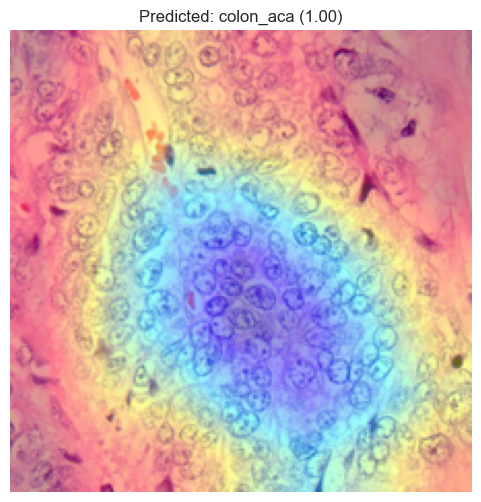

In [21]:
# Select a sample image from the dataset
sample_image_path = df["filepaths"].iloc[0]  

# Use the last convolutional layer
target_layer = model._conv_head  # Correct last conv layer for model

# Run Grad-CAM with overlay
apply_grad_cam_overlay(model, sample_image_path, target_layer, class_to_idx)


In [22]:
import shap
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Create SHAP Explainer
def get_shap_explainer(model):
    """
    Returns a SHAP explainer for the model.
    """
    background = torch.zeros((1, 3, 224, 224)).to(DEVICE)  # Baseline for SHAP
    explainer = shap.GradientExplainer(model, background)
    return explainer

def explain_image_shap(model, image_path, class_to_idx):
    """
    Uses SHAP to explain an image classification and displays
    the original image and explanation side by side.
    """
    model.eval()

    # Define transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Get model prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_class = list(class_to_idx.keys())[list(class_to_idx.values()).index(pred_idx)]

    # Get SHAP explainer
    explainer = get_shap_explainer(model)

    # Compute SHAP values
    shap_values = explainer.shap_values(image_tensor)

    # Convert image to numpy for visualization
    image_np = np.array(image.resize((224, 224)))  # Resize for consistency

    # Plot Original and SHAP Explanation Side-by-Side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    # SHAP Explanation
    shap.image_plot(shap_values, image_tensor.cpu().numpy(), show=False)
    plt.sca(axes[1])
    plt.imshow(shap_values[0][0].transpose(1, 2, 0), cmap="coolwarm")
    plt.axis("off")
    plt.title(f"SHAP Explanation: {pred_class} ({probs.max().item():.2f})")

    plt.tight_layout()
    plt.show()


In [23]:
# Select a sample image from the dataset
sample_image_path = df["filepaths"].iloc[2]  

# Run SHAP explanation
explain_image_shap(model, sample_image_path, class_to_idx)


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.71 GiB is allocated by PyTorch, and 63.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [24]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load your trained model
model_path = "efficientnet_colon_cancer.pth"  # Adjust if necessary
model = torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Load and preprocess image
image_path = "path_to_your_image.jpg"  # Replace with an actual image path
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).requires_grad_(True)  # Add batch dimension

# Forward pass
input_tensor = input_tensor.to("cuda" if torch.cuda.is_available() else "cpu")
output = model(input_tensor)

# Get the predicted class index
predicted_class = output.argmax(dim=1).item()

# Compute gradients
output[0, predicted_class].backward()  # Compute gradients for the predicted class
saliency, _ = torch.max(input_tensor.grad.abs(), dim=1)  # Get the max across channels

# Convert to NumPy for visualization
saliency_map = saliency.squeeze().cpu().detach().numpy()

# Plot original image and saliency map
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title("Original Image")

# Saliency map
ax[1].imshow(saliency_map, cmap="hot")
ax[1].axis("off")
ax[1].set_title("Saliency Map")

plt.show()


C:\Users\tobio\AppData\Local\Temp\ipykernel_14644\2829837450.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location="cuda" if torch.

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.72 GiB is allocated by PyTorch, and 62.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)